**Ultimate Challenge Part 3**

We'll start by importing and exploring the data and then I wil summarize my findings below.

In [162]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import *
%matplotlib inline

with open(r'C:\Users\Pujanande\Desktop\Data\ultimate_challenge\ultimate_data_challenge.json') as f:
    data = json.load(f) #import data
data = pd.DataFrame(data) #load data into df
data.dtypes #check data types

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
ultimate_black_user          bool
weekday_pct               float64
dtype: object

In [163]:
for column in data: #check data completness
    print(column, data[column].isnull().sum())

avg_dist 0
avg_rating_by_driver 201
avg_rating_of_driver 8122
avg_surge 0
city 0
last_trip_date 0
phone 396
signup_date 0
surge_pct 0
trips_in_first_30_days 0
ultimate_black_user 0
weekday_pct 0


The question deifnes a retained user as one who was active in the last 30 days. First we need to identify hat time period we are workingwith.

In [164]:
data.last_trip_date = pd.to_datetime(data.last_trip_date)
print(data.last_trip_date.max())
print(data.last_trip_date.min())

2014-07-01 00:00:00
2014-01-01 00:00:00


July 1 was the last date. This emans any user active in June or latter can be considered retained.

In [165]:
data['last_trip_month'] = data['last_trip_date'].dt.month
print('Fraction of retained users:',(data.last_trip_month[data.last_trip_month >= 6].count()/data.last_trip_month.count()))

Fraction of retained users: 0.37608


37% of users that signed up in January were retained. I'll create a column that classifes an observation as retianed or not for our target. Since information about the last trip is what we're tryng to predict I'll drop that as well. Further, I'll transform signup day to day of the week as that will proccess better in the predictive models.

In [166]:
#create a column for the classifer
data['retained'] = 0 #not retained
data['retained'][(data['last_trip_month'] >= 6)]= 1 #yes retained

print(data.last_trip_month[data.last_trip_month >= 6].count()) #check to make sure they are equal
print(data.retained.sum())

data['signup_date'] = pd.to_datetime(data.signup_date)
data['signupdayofweek'] = data['signup_date'].dt.weekday #make a weekday variable

data_2 = data.drop(data[['last_trip_month','last_trip_date','signup_date']],axis=1) #drop these columns in favor of classifer target

18804
18804


C:\Users\Pujanande\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Now that I have my data set I'll explore it with some standard visulizations.

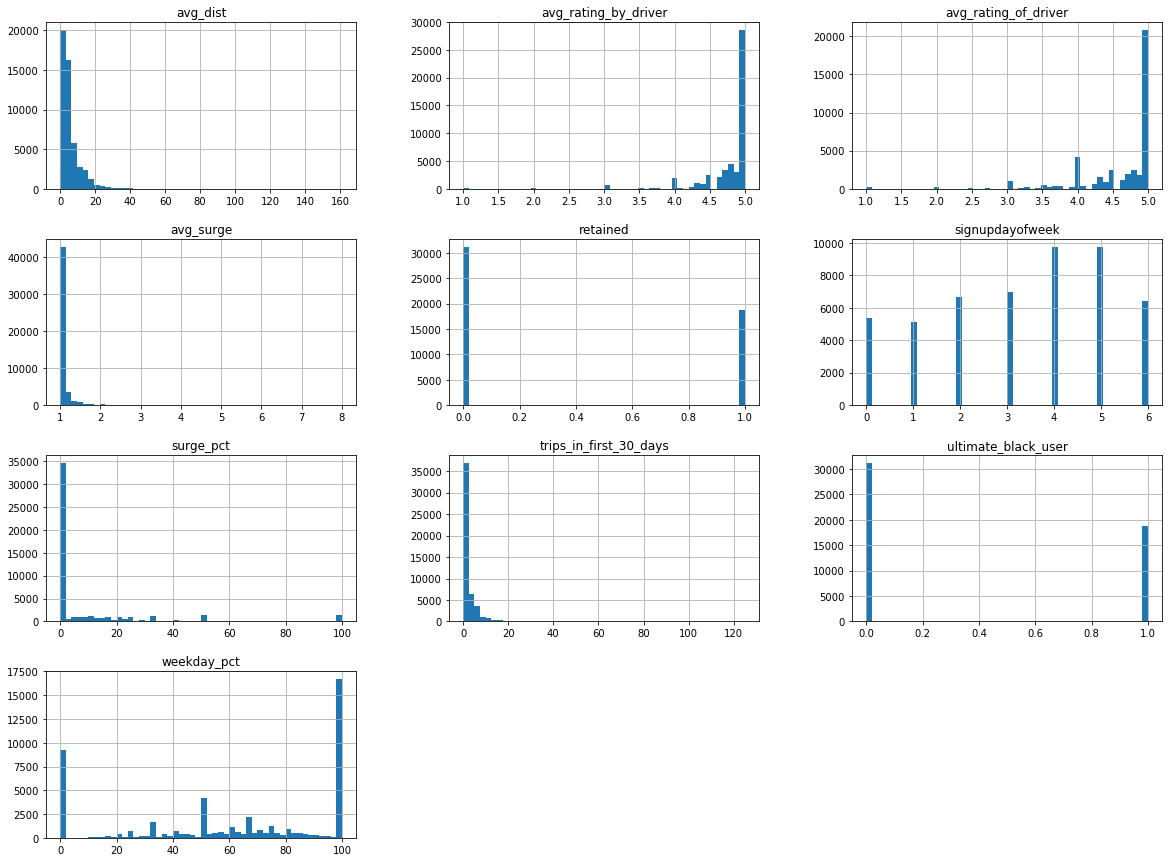

In [167]:
data_2.hist(bins=50, figsize=(20,15)) #visulize all columns
plt.show()

See what columns ar the most correlated with the target.

In [168]:
corr_matrix = data_2.corr()
corr_matrix["retained"].sort_values(ascending=False)

retained                  1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
signupdayofweek           0.000042
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: retained, dtype: float64

Now that I have an idea what the data looks like's time to prep it for the model. I will be converting the non-numeric data to labels and I will normalize the non numeric data. The only columns with NaN's are the rating columns, presumably since no rating was given. I can either toss these, or assume that these were the average. Since I don't want to lose the observations, for now I'll keep them and use imputer to fill in the mean.

In [169]:
y = data_2['retained'] #target
x_non_numeric = data_2[['city','ultimate_black_user','phone','signupdayofweek']] #non-numeric to be labeled

for column in x_non_numeric : #make sure all non-numerics are strings
        x_non_numeric[column] = x_non_numeric[column].astype(str)

x_non_numeric = x_non_numeric.apply(preprocessing.LabelEncoder().fit_transform) #apply labeling

x_numeric_1 = data_2.drop(data_2[['retained','city','ultimate_black_user','phone','signupdayofweek']],axis=1) #numeric
x_num_array = x_numeric.values #returns a numpy array

imputer = preprocessing.Imputer()
scaler = preprocessing.StandardScaler()

x_num_array = imputer.fit_transform(x_num_array) #fill NaN
x_num_array = scaler.fit_transform(x_num_array) #normalize
x_numeric = pd.DataFrame(x_num_array) #remake a dataframe
x_numeric.columns = x_numeric_1.columns #read column names
x = pd.concat([x_numeric, x_non_numeric], axis=1,join_axes=[x_non_numeric.index]) #rejoin axis

C:\Users\Pujanande\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now that we have clean data and a target it's time to choose a model. For simplicty sake, lets try several different models including a voting classifer to see which performs best.

In [170]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.33, random_state=42) #split data

LR = linear_model.LogisticRegression(random_state=42) #set models
RF = ensemble.RandomForestClassifier(random_state=42)
KNN = neighbors.KNeighborsClassifier()
VC = ensemble.VotingClassifier(estimators=[('LR', LR), ('RF', RF), ('KNN', KNN)], voting='hard')

LR_model = LR.fit(x_train,y_train) #fit models
RF_model = RF.fit(x_train,y_train)
KNN_model = KNN.fit(x_train,y_train)
VC_model = VC.fit(x_train,y_train)

y_pred_LR = LR_model.predict(x_test) #predict test data
y_pred_RF = RF_model.predict(x_test)
y_pred_KNN = KNN_model.predict(x_test)
y_pred_VC = VC_model.predict(x_test)

score_LR = metrics.accuracy_score(y_test,y_pred_LR) #compute scores
score_RF = metrics.accuracy_score(y_test,y_pred_RF)
score_KNN = metrics.accuracy_score(y_test,y_pred_KNN)
score_VC = metrics.accuracy_score(y_test,y_pred_VC)

print('LR:',score_LR) #print scores
print('RF:',score_RF)
print('KNN:',score_KNN)
print('VC:',score_VC)

LR: 0.694666666667
RF: 0.748242424242
KNN: 0.733878787879
VC: 0.751333333333


The voting classifer model performs the best. We could tweek this model more to make it better, however, the ultimate assigment is to make recommendations. With that in mind, I will instead figure out which features are most important to this models accuracy. To do this I will creat a function that goes through the data frame, removes a single feature, refits the model,and computes the score. The model that performs the worst will be the model with the most important feature removed. This model has a 75% acurracy score, meaning there's a 75% chance of correctly predicting a customers retention rate.

In [186]:
def find_import(x,y) :
    d_list =list(x) #list columns
    scores = {} #dict for scores
    
    for column in d_list : #for each column...
        x_2 = x.drop(x[[column]],axis=1) #drop that column
        
        #perform identical voting classifer model as the one above
        x_train, x_test, y_train, y_test = model_selection.train_test_split(x_2, y, test_size=0.33, random_state=42)

        LR = linear_model.LogisticRegression(random_state=42)
        RF = ensemble.RandomForestClassifier(random_state=42)
        KNN = neighbors.KNeighborsClassifier()
        VC = ensemble.VotingClassifier(estimators=[('LR', LR), ('RF', RF), ('KNN', KNN)], voting='hard')
    
        VC_model = VC.fit(x_train,y_train)
        y_pred_VC = VC_model.predict(x_test)
        score_VC = metrics.accuracy_score(y_test,y_pred_VC)
        scores[column] = score_VC
        
    return scores #return full dict of scores

Run once to determine most important

In [187]:
first = find_import(x,y)
first

{'avg_dist': 0.752,
 'avg_rating_by_driver': 0.7459393939393939,
 'avg_rating_of_driver': 0.75284848484848488,
 'avg_surge': 0.75054545454545452,
 'city': 0.7305454545454545,
 'phone': 0.74309090909090914,
 'signupdayofweek': 0.75490909090909086,
 'surge_pct': 0.75048484848484853,
 'trips_in_first_30_days': 0.75048484848484853,
 'ultimate_black_user': 0.74315151515151512,
 'weekday_pct': 0.74612121212121207}

The model that had dropped city performed the worst. Lets fin the second most important by dropping that feature from the input data altogether.

In [189]:
x_2 = x.drop(x[['city']],axis=1)

second = find_import(x_2,y)
second

{'avg_dist': 0.73260606060606059,
 'avg_rating_by_driver': 0.72072727272727277,
 'avg_rating_of_driver': 0.73139393939393937,
 'avg_surge': 0.72775757575757571,
 'phone': 0.71672727272727277,
 'signupdayofweek': 0.73187878787878791,
 'surge_pct': 0.72539393939393937,
 'trips_in_first_30_days': 0.72575757575757571,
 'ultimate_black_user': 0.71812121212121216,
 'weekday_pct': 0.71993939393939399}

This time phone performed the worse. Lets try one more.

In [190]:
x_3 = x_2.drop(x_2[['phone']],axis=1)

third = find_import(x_3,y)
third

{'avg_dist': 0.72157575757575754,
 'avg_rating_by_driver': 0.71303030303030301,
 'avg_rating_of_driver': 0.71903030303030302,
 'avg_surge': 0.71618181818181814,
 'signupdayofweek': 0.72169696969696973,
 'surge_pct': 0.71466666666666667,
 'trips_in_first_30_days': 0.71375757575757581,
 'ultimate_black_user': 0.71072727272727276,
 'weekday_pct': 0.71442424242424241}

Alot of the worse models are very close. There is no clear standout for a third most important feature. Lets take a closer look at our two most important features.

In [210]:
print('Retained users Astapor:',((data.city[(data.city == 'Astapor') & (data.retained == 1)].count()) /data.city[data.city == 'Astapor'].count()))
print("Retained user King's Landing:",((data.city[(data.city == "King's Landing") & (data.retained == 1)].count()) /data.city[data.city == "King's Landing"].count()))
print('Retained users Winterfell:',((data.city[(data.city == "Winterfell") & (data.retained == 1)].count()) /data.city[data.city == "Winterfell"].count()))
print(' ')
print('Retained users Android:',((data.phone[(data.phone == "Android") & (data.retained == 1)].count()) /data.phone[data.phone == "Android"].count()))
print('Retained users iPhone:',((data.phone[(data.phone == "iPhone") & (data.retained == 1)].count()) /data.phone[data.phone == "iPhone"].count()))

Retained users Astapor: 0.255715495343
Retained user King's Landing: 0.628134254689
Retained users Winterfell: 0.351945491944
 
Retained users Android: 0.209426174943
Retained users iPhone: 0.44893297091


**Summary**

The above analysis clearly shows that if Ultimate Inc wants to improve its retention rate it should focus on improving its service in Astapor and Winterfell, as these cities have mcuh lower rates of retention than King's Landing. Possible causes for this could be not enough availble drivers, long wait times, and high surge costs. A further recommendation would be to improve its android app. Adroid users are 25% more likely to not be retained.